# Python Interactive Example: TinyMPC-Based Predictive Safety Filter on Double Integrator

In this demonstration, we showcase an interactive Python workflow using TinyMPC for safety filter. You can generate C++ code and engage with it seamlessly within the Python environment.

If any issues arise, restart the kernel.

Load necessary packages, make sure to install `tinympc` ([README.md](../README.md))

In [ ]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate()

using Libdl
using Random
using PyPlot
using LinearAlgebra

include(joinpath(@__DIR__,"../tinympc/TinyMPC.jl"))
using .TinyMPC
include("visualization.jl") # for visualization

## Double Integrator System

In [222]:
NSTATES = 6
NINPUTS = 3
NHORIZON = 30
NTOTAL = 201

# Double-integrator dynamics
h = 0.05 #20 Hz
temp_n = Int(NSTATES/2)
Adyn = [I(temp_n) h*I(temp_n); zeros(temp_n,temp_n) I(temp_n)]
Bdyn = [0.5*h*h*I(temp_n); h*I(temp_n)];

t = h*(0:NTOTAL-1)
Xref = zeros(NSTATES, NTOTAL)
for k = 1:NTOTAL
  Xref[1:3,k] = sin(1*t[k])*2*ones(temp_n)
end
Uref = repeat([0; 0; 0.0], 1, NTOTAL-1) 


3×200 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

## Code Generation

Now, let's define the class and compile original TinyMPC code to get a generic shared/dynamic library

**PLEASE CHANGE `tinympc_julia_dir` TO YOUR ABSOLUTE PATH**

In [223]:
tinympc_julia_dir = "/home/khai/SSD/Code/tinympc-julia"  # Your absolute path to the tinympc-Julia directory, you need to change this
tinympc_dir = tinympc_julia_dir * "/tinympc/TinyMPC"  # Path to the TinyMPC directory (C code)
TinyMPC.compile_lib(tinympc_dir)  # Compile the C code into a shared library

Compiling library to /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC
-- Configuring done


-- Generating done
-- Build files have been written to: /home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/build


Consolidate compiler generated dependencies of target tinympcShared
[ 18%] Built target tinympcShared


Consolidate compiler generated dependencies of target tinympc
[ 37%] Built target tinympc


Consolidate compiler generated dependencies of target codegen_cartpole
[ 50%] Built target codegen_cartpole


Consolidate compiler generated dependencies of target codegen_random
[ 62%] Built target codegen_random


Consolidate compiler generated dependencies of target quadrotor_hovering
[ 75%] Built target quadrotor_hovering


Consolidate compiler generated dependencies of target quadrotor_tracking
[ 87%] Built target quadrotor_tracking
Consolidate compiler generated dependencies of target test1
[100%] Built target test1


true

Load the generic shared/dynamic library. **You may want to change the extension of the library based on your OS -- Linux: .so, Mac: .dylib, Windows: .dll**

In [224]:
os_ext = ".so"  # CHANGE THIS BASED ON YOUR OS
tinympc = tinympc_dir * "/build/src/tinympc/libtinympcShared" * os_ext  # Path to the compiled library

"/home/khai/SSD/Code/tinympc-julia/tinympc/TinyMPC/build/src/tinympc/libtinympcShared.so"

Here we setup problem data and settings for TinyMPC

In [225]:
# convert A to array column major
Acol = cat(Adyn..., dims=2)[:]
Bcol = cat(Bdyn..., dims=2)[:]
display(Acol')
display(Bcol')
Q = zeros(NSTATES) # dont need to penalize the state in safety fitler
R = 1e2*ones(NINPUTS)
rho = 5e2

###### Bounds
xmin = -1. * ones(NSTATES*NHORIZON)  # state constraints
xmax = 1. * ones(NSTATES*NHORIZON)  # state constraints
umin = -3 * ones(NINPUTS*(NHORIZON-1))  # force constraints
umax = 3 * ones(NINPUTS*(NHORIZON-1))  # force constraints

##### Settings
abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 50
check_termination = 1

1×36 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.05  0.0  0.0  1.0

1×18 adjoint(::Vector{Float64}) with eltype Float64:
 0.00125  0.0  0.0  0.05  0.0  0.0  0.0  …  0.0  0.0  0.00125  0.0  0.0  0.05

1

After define the problem, we generate the tailored code with above data. 

**Here we compile it for interactive Julia script but you can use it directly for your applications/systems**

Since Julia does JIT compilation, we cannot wrap C functions now -- we haven't generated the C code yet!. Therefore, we need to call the C function using `ccall` directly, which doesn't look nice :(

In [226]:
output_dir = tinympc_julia_dir * "/generated_code1"  # Path to the generated code

@ccall tinympc.tiny_codegen(NSTATES::Cint, NINPUTS::Cint, NHORIZON::Cint, Acol::Ptr{Float64}, Bcol::Ptr{Float64}, Q::Ptr{Float64}, R::Ptr{Float64}, xmin::Ptr{Float64}, xmax::Ptr{Float64}, umin::Ptr{Float64}, umax::Ptr{Float64}, rho::Float64, abs_pri_tol::Float64, abs_dua_tol::Float64, max_iter::Cint, check_termination::Cint, 1::Cint, tinympc_dir::Ptr{UInt8}, output_dir::Ptr{UInt8})::Cint

TinyMPC.compile_lib(output_dir)

A = [   1,    0,    0, 0.05,    0,    0]
[   0,    1,    0,    0, 0.05,    0]
[   0,    0,    1,    0,    0, 0.05]
[   0,    0,    0,    1,    0,    0]
[   0,    0,    0,    0,    1,    0]
[   0,    0,    0,    0,    0,    1]
B = [0.00125,       0,       0]
[      0, 0.00125,       0]
[      0,       0, 0.00125]
[   0.05,       0,       0]
[      0,    0.05,       0]
[      0,       0,    0.05]
Q = [500,   0,   0,   0,   0,   0]
[  0, 500,   0,   0,   0,   0]
[  0,   0, 500,   0,   0,   0]
[  0,   0,   0, 500,   0,   0]
[  0,   0,   0,   0, 500,   0]
[  0,   0,   0,   0,   0, 500]
R = [600,   0,   0]
[  0, 600,   0]
[  0,   0, 600]
rho = 500
Kinf converged after 134 iterations
Precomputing finished
Kinf = [0.8763,      0,      0,  1.588,      0,      0]
[     0, 0.8763,      0,      0,  1.588,      0]
[     0,      0, 0.8763,      0,      0,  1.588]
Pinf = [1.812e+04,         0,         0, 1.096e+04,         0,         0]
[        0, 1.812e+04,         0,         0, 1.096e+04,         

1

## Interactive Program (WIP)

Run the interactive example which calls the generated code.

Since this works with pointers, underlying data is persistent in each kernel session (something like deepcopy/shallowcopy or pass by reference/value). If you want to run from the original setup, you may need to change data back or 
restart kernel.

### Nominal Controller

In [228]:
Knom = [4.77182  0.0      0.0      5.68453  0.0      0.0;
        0.0      4.77182  0.0      0.0      5.68453  0.0;
        0.0      0.0      4.77182  0.0      0.0      5.68453]  # nominal gain

# rollout the closed-loop system to get future control inputs
function rollout!(Upred, x, Xref_hrz, integral)    
    xn = x*1
    for k = 1:NHORIZON-1
        integral += (Xref_hrz[1:3,k] - xn[1:3])
        # Upred[:,k] = -1*Knom*(xn - Xref_hrz[:,k]) + 20.0*integral
        Upred[:,k] = [-4.0; 4.0; -4.0]  # constant control input
        xn = Adyn*xn + Bdyn*Upred[:,k]
    end
end

rollout! (generic function with 1 method)

### TinyMPC-based Safety Filter

In [229]:
# Control loop
en_safety_filter = 1 # ENABLE SAFETY FILTER OR NOT

tinympc = output_dir * "/build/tinympc/libtinympcShared" * os_ext  # Path to the compiled library
u = Array{Float32}(zeros(NINPUTS*(NHORIZON-1)))  # List of control inputs in horizon
Random.seed!(1234)
Xhist = zeros(NSTATES, NTOTAL)
x0 = zeros(NSTATES)
Xhist[:,1] .= x0 + randn(NSTATES)*0
Uhist = zeros(NINPUTS, NTOTAL-1)
Upred = zeros(NINPUTS, NHORIZON-1)
integral = zeros(NINPUTS)

NRUNS = NTOTAL-NHORIZON-1  
for i = 1:1
    # i%10 == 0 && print("i = ", i, "\n")
    # Get measurements
    pos_norm = norm(Xhist[1:3, i], Inf) / 1e2 # 1% noise
    vel_norm = norm(Xhist[4:6, i], Inf) / 1e4 # 1ppm noise
    noise_pos = randn(3)
    noise_vel = randn(3)
    xk = Xhist[:,i] + 0*[noise_pos * pos_norm; noise_vel * vel_norm]
    
    # Nominal control rollout
    rollout!(Upred, xk, Xref[:,i:i+NHORIZON-1], integral)
    Uhist[:,i] .= Upred[:,1]
    display(Upred)
    
    # Solve safety filter
    if en_safety_filter  == 1
        xk = Array{Float32}(xk)
        @ccall tinympc.set_x0(xk::Ptr{Float32}, 1::Cint)::Cvoid

        Upred_ = Array{Float32}(Upred)  # col-major array
        # print(Upred_, "\n")
        @ccall tinympc.set_uref(Upred_::Ptr{Float32}, 1::Cint)::Cvoid

        @ccall tinympc.call_tiny_solve(0::Cint)::Cvoid

        # Get the control input
        @ccall tinympc.get_u(u::Ptr{Float32}, 1::Cint)::Cvoid
        # println(u)
        # Uhist[:,i] .= u[0:NINPUTS]
    end

    # Clamp control input
    # Uhist[:,i] = max.(min.(Uhist[:,i], umax[:,1]), umin[:,1])

    # print(Upred, "\n")
    # print(solver.workspace.u, "\n")
    # print(solver.workspace.x, "\n")

    # Simulate
    Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i]
end

3×29 Matrix{Float64}:
 -4.0  -4.0  -4.0  -4.0  -4.0  -4.0  …  -4.0  -4.0  -4.0  -4.0  -4.0  -4.0
  4.0   4.0   4.0   4.0   4.0   4.0      4.0   4.0   4.0   4.0   4.0   4.0
 -4.0  -4.0  -4.0  -4.0  -4.0  -4.0     -4.0  -4.0  -4.0  -4.0  -4.0  -4.0

set_x0 result:  0.000000
set_x0 result:  0.000000
set_x0 result:  0.000000
set_x0 result:  0.000000
set_x0 result:  0.000000
set_x0 result:  0.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4.000000
set_xref result:  4.000000
set_xref result:  -4.000000
set_xref result:  -4

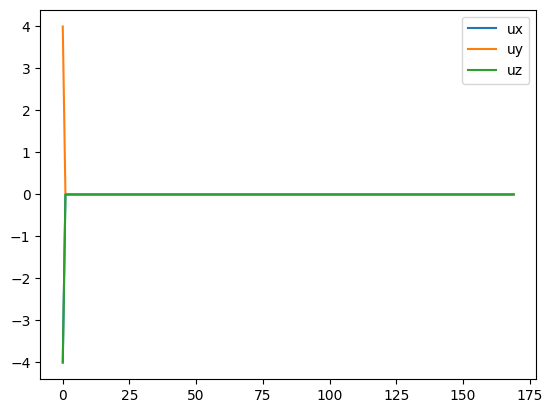

In [230]:
fig = plt.figure()
plot(Uhist[1, 1:NRUNS])
plot(Uhist[2, 1:NRUNS])
plot(Uhist[3, 1:NRUNS])
plt.legend(["ux", "uy", "uz"])
fig

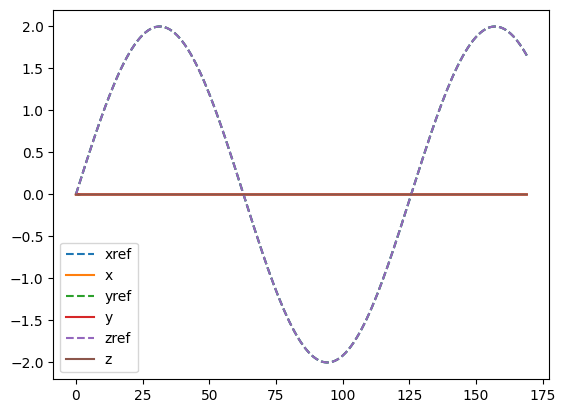

In [231]:
fig = plt.figure()
plot(Xref[1,1:NRUNS], "--")
plot(Xhist[1,1:NRUNS])
plot(Xref[2,1:NRUNS], "--") 
plot(Xhist[2,1:NRUNS])
plot(Xref[3,1:NRUNS], "--") 
plot(Xhist[3,1:NRUNS])
plt.legend(["xref", "x", "yref", "y", "zref", "z"])
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

Post testing the procedure with the generated code, the next step involves deploying it for your specific applications/systems.
The workflow for deployment is tailored to your specific needs, and we aim to provide clear guidance.

Your `tiny_main` may look like this

```C
#include <iostream>

#include <tinympc/admm.hpp>
#include <tinympc/tiny_data_workspace.hpp>

using namespace Eigen;
IOFormat CleanFmt(4, 0, ", ", "\n", "[", "]");

#ifdef __cplusplus
extern "C" {
#endif

#define NTOTAL 201
#define NRUNS (NTOTAL - NHORIZON - 1)
#define dt 0.05

float kp = 7.0;
float kd = 3.0;
float ki = 0.1;

Vector3f integral;
tiny_VectorNx xk;
tiny_VectorNx xhrz;
tiny_VectorNx xd;
tiny_VectorNu uk;

int main()
{
	int NPOS = int(NSTATES/2);
	int exitflag = 1;
	// Double check some data
	// std::cout << tiny_data_solver.settings->max_iter << std::endl;
	// std::cout << tiny_data_solver.cache->AmBKt.format(CleanFmt) << std::endl;
	// std::cout << tiny_data_solver.work->Adyn.format(CleanFmt) << std::endl;
	tiny_data_solver.settings->en_state_bound = 1;
	tiny_data_solver.settings->max_iter = 100;

	for (int i = 0; i < NHORIZON-1; i++)
	{
		tiny_data_solver.work->x_min.col(i) = -1.0 * tiny_VectorNx::Ones();
		tiny_data_solver.work->x_max.col(i) = 1.0 * tiny_VectorNx::Ones();
		// tiny_data_solver.work->u_min.col(i) << -3, -3, -1;
		// tiny_data_solver.work->u_max.col(i) << 1, 1, 1;
	}

	srand(1);
	xk = tiny_VectorNx::Random()*0.1;

	for (int i = 0; i < NRUNS; i++)
	{
		xhrz << xk;
		// Rollout the nominal system
		for (int k = 0; k < NHORIZON-1; k++) {
			float temp = 2.0*sin(1*dt*i);
			xd(seq(0,NPOS-1)) = temp * VectorXf::Ones(NPOS);
			// pid controller
			integral = integral + (xd(seq(0,NPOS-1)) - xhrz(seq(0,NPOS-1)))*dt;
			tiny_data_solver.work->Uref.col(k) << kp*(xd(seq(0,NPOS-1)) - xhrz(seq(0,NPOS-1))) + kd*(xd(seq(NPOS,NSTATES-1)) - xhrz(seq(NPOS,NSTATES-1))) + 0*integral;
			xhrz = tiny_data_solver.work->Adyn * xhrz + tiny_data_solver.work->Bdyn * tiny_data_solver.work->Uref.col(k);
		}
		uk = tiny_data_solver.work->Uref.col(0);
		
		if (1) {  // enable safety filter
		tiny_data_solver.work->x.col(0) << xk;

		exitflag = tiny_solve(&tiny_data_solver);

		uk = tiny_data_solver.work->u.col(0);

		if (exitflag != 1) printf("OOPS! Something went wrong!\n");

		// std::cout << tiny_data_solver.work->u.format(CleanFmt) << std::endl;
		}
		xk = tiny_data_solver.work->Adyn * xk + tiny_data_solver.work->Bdyn * uk;
		std::cout << "xk = " << xk.transpose() << std::endl;
		std::cout << "uk = " << uk.transpose() << "\n" << std::endl;
	}
	return 0;
}

#ifdef __cplusplus
} /* extern "C" */
#endif

```